In [3]:
import PIL
import torch
import numpy as np
from time import time
from itertools import chain
import matplotlib.pyplot as plt
from batchflow import dataset, Pipeline, P, R, B, V
from batchflow.opensets import MNIST
from torch.nn import CrossEntropyLoss
from batchflow.models.torch import UNet

from utils import plot_pred_mask
from batch import MyBatch
from utils import plot_augm_masks
%load_ext autoreload
%autoreload 2

In [90]:
dataset = MNIST(batch_class=MyBatch)

http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
ExtractingExtracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
 /tmp/t10k-images-idx3-ubyte.gz


In [209]:
bg_shape=(128,128)
augmentation = (Pipeline()
                 .rotate(angle=P(R('uniform', -35, 35)))
                 .scale(factor=P(R('uniform', 2, 3)), 
                        origin='random')
                 .background_and_mask(bg_shape)
                 .invert(channels=P(R('randint', 0, 3)), p=0.5)
                 .noise(n=1)
                 .preprocess_images()
               )

In [210]:
pipeline = augmentation << dataset.test
batch = pipeline.next_batch(32, shuffle=True)

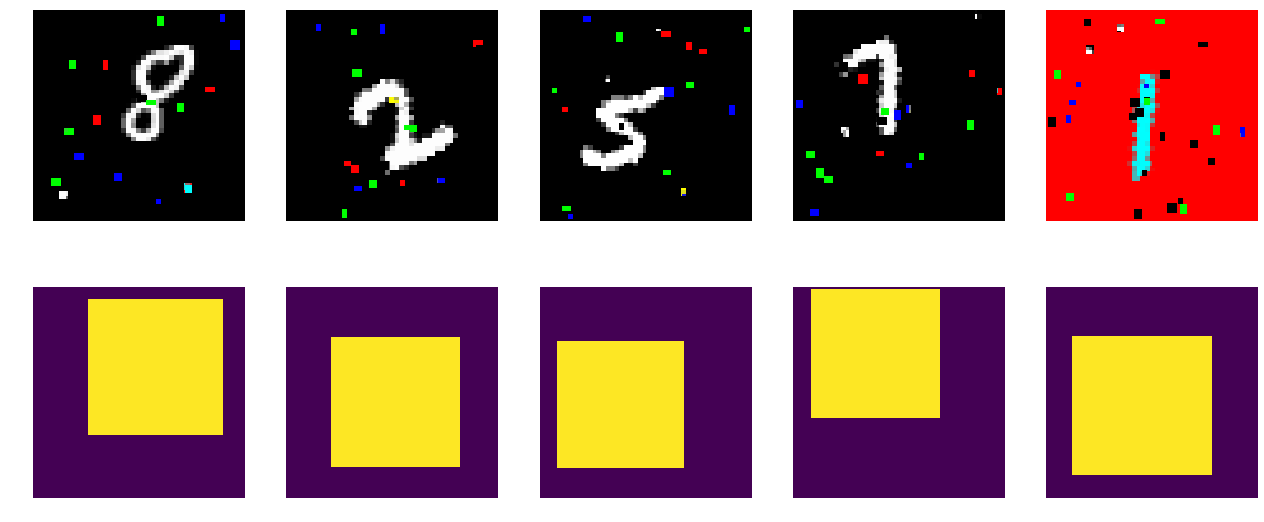

In [211]:
plot_augm_masks(batch)

In [212]:
inputs_config = {
    'images': {'shape': (3, *bg_shape)},
    'masks': {'shape': bg_shape,
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

In [234]:
%env CUDA_VISIBLE_DEVICES=1
config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'images',
    'loss': 'ce',
    'optimizer': ('Adam', {'lr': 0.01}),
    'device': 'cuda:0',
    'head/num_classes': 2, 
    'body/num_blocks': 4
     
}

env: CUDA_VISIBLE_DEVICES=1


In [241]:
train_pipeline = (augmentation
                  + Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .train_model('my_model', B('images'), B('masks'),
                                   fetches='loss')#, save_to=V('loss'), mode='a')
                 ) << dataset.train 

In [242]:
start = time()
for _ in range(2000):
    train_pipeline.next_batch(32, shuffle=True, n_epochs=None)
stop = time()
print('Training time - {:05.3f} min'.format((stop-start)/60))

Training time - 16.956 min


In [243]:
test_pipeline = (augmentation
                 +Pipeline()
                    .import_model('my_model', train_pipeline)
                    .init_variable('predictions')
                    .init_variable('metrics')
                    .predict_model('my_model', B('images'),
                                   fetches='predictions', save_to=V('predictions'))
                    .gather_metrics('mask', targets=B('masks'), fmt='logits', axis=1,
                                    predictions=V('predictions'), num_classes=2, save_to=V('metrics'), mode='u')
                ) << dataset.test

In [253]:
test_batch = test_pipeline.next_batch(32, shuffle=True)
pred=test_pipeline.get_variable('predictions')
metrics = test_pipeline.get_variable('metrics')
metrics.evaluate('true_positive_rate')

0.822723907050769

In [254]:
print(metrics.evaluate('iou'))

0.7220624795433334


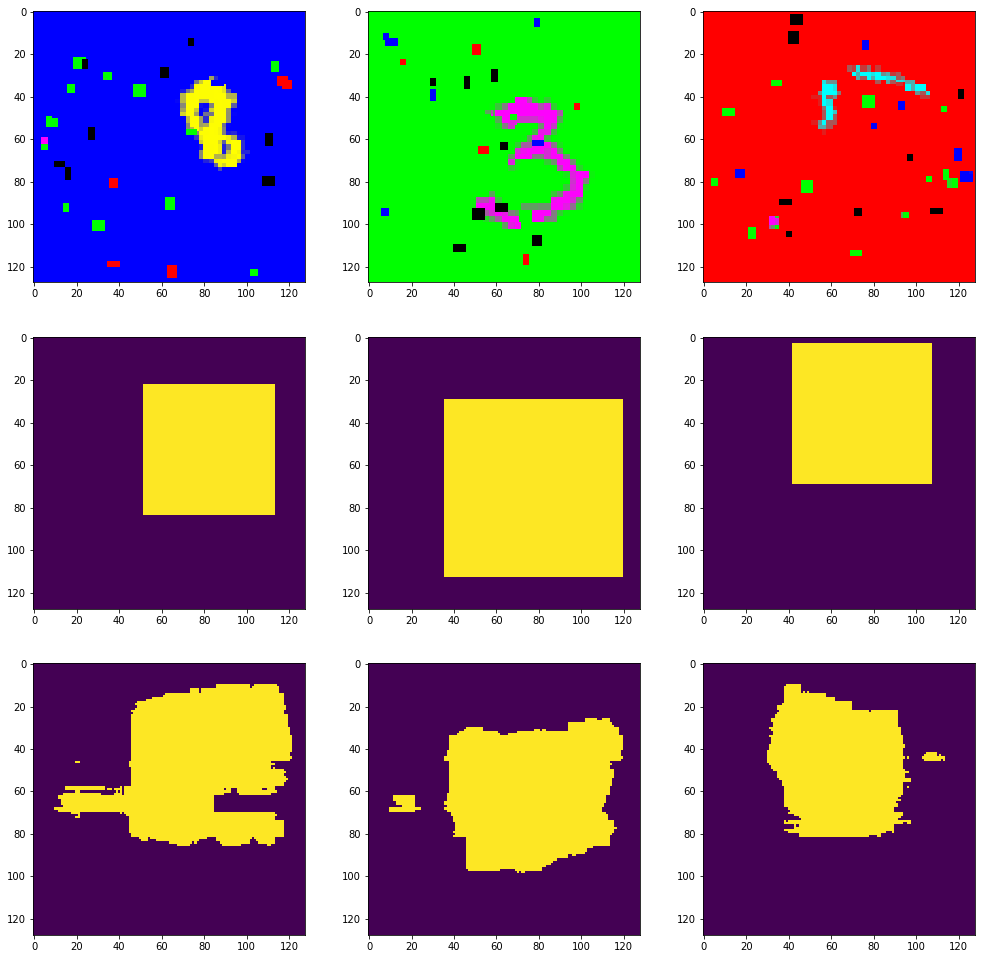

In [255]:
%autoreload 2
from utils import plot_pred_mask
plot_pred_mask(test_batch, pred)